In [1]:
# Remove input cells at runtime (nbsphinx)
import IPython.core.display as d
d.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# Particle classification (DL2)

**WARNING**

This is still a work-in-progress, it will evolve with the pipeline comparisons and converge with ctaplot+cta-benchmarks.

Part of this notebook is performed by `protopipe.scripts.model_diagnostics` which will be discontinued.

**Author(s):**
    
- Dr. Michele Peresano (CEA-Saclay/IRFU/DAp/LEPCHE), 2020

based on previous work by J. Lefacheur.

**Description:**

This notebook contains benchmarks for the _protopipe_ pipeline regarding particle classification.
Additional information is provided by `protopipe.scripts.model_diagnostics`, which will eventually be merged here.

**NOTES:**
- these benchmarks will be cross-validated and migrated in cta-benchmarks/ctaplot,
- follow [this](https://www.overleaf.com/16933164ghbhvjtchknf) document by adding new benchmarks or proposing new ones.

**Requirements:**

To run this notebook you will need a set of trained data produced on the grid with protopipe.
The MC production to be used and the appropriate set of files to use for this notebook can be found [here](https://forge.in2p3.fr/projects/step-by-step-reference-mars-analysis/wiki#The-MC-sample ).

The data format required to run the notebook is the current one used by _protopipe_ .
Later on it will be the same as in _ctapipe_ + _pyirf_.

**Development and testing:**  

For the moment this notebook is optimized to work only on files produced from LSTCam + NectarCam telescope configurations.  
As with any other part of _protopipe_ and being part of the official repository, this notebook can be further developed by any interested contributor.  
The execution of this notebook is not currently automatic, it must be done locally by the user - preferably _before_ pushing a pull-request.  
**IMPORTANT:** Please, if you wish to contribute to this notebook, before pushing anything to your branch (better even before opening the PR) clear all the output and remove any local directory paths that you used for testing (leave empty strings).

**TODO:**  
* check any missing model diagnostics product
* add remaining benchmarks from CTA-MARS comparison
* same for EventDisplay

## Table of contents
   - [Estimate distribution](#Estimate-distribution)
   - [ROC curve](#ROC-curve)

## Imports

In [2]:
%matplotlib inline
import os
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import auc, roc_curve

## Functions

In [3]:
def load_config(name):
    """Load YAML configuration file."""
    try:
        with open(name, "r") as stream:
            cfg = yaml.load(stream, Loader=yaml.FullLoader)
    except FileNotFoundError as e:
        print(e)
        raise
    return cfg

def plot_hist(ax, data, nbin, limit, norm=False, yerr=False, hist_kwargs={}, error_kw={}):
    """Utility function to plot histogram"""
    bin_edges = np.linspace(limit[0], limit[-1], nbin + 1, True)
    y, tmp = np.histogram(data, bins=bin_edges)
    weights = np.ones_like(y)
    if norm is True:
        weights = weights / float(np.sum(y))
    if yerr is True:
        yerr = np.sqrt(y) * weights
    else:
        yerr = np.zeros(len(y))

    centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    width = bin_edges[1:] - bin_edges[:-1]
    ax.bar(centers, y * weights, width=width, yerr=yerr, error_kw=error_kw, **hist_kwargs)

    return ax

def plot_roc_curve(ax, model_output, y, **kwargs):
    """Plot ROC curve for a given set of model outputs and labels"""
    fpr, tpr, _ = roc_curve(y_score=model_output, y_true=y)
    roc_auc = auc(fpr, tpr)
    label = '{} (area={:.2f})'.format(kwargs.pop('label'), roc_auc)  # Remove label
    ax.plot(fpr, tpr, label=label, **kwargs)
    return ax

def plot_evt_roc_curve_variation(ax, data_test, cut_list, model_output_name):
    """

    Parameters
    ----------
    ax: `~matplotlib.axes.Axes`
        Axis
    data_test: `~pd.DataFrame`
        Test data
    cut_list: `list`
         Cut list

    Returns
    -------
    ax:  `~matplotlib.axes.Axes`
        Axis
    """
    color = 1.
    step_color = 1. / (len(cut_list))
    for i, cut in enumerate(cut_list):
        c = color - (i + 1) * step_color

        data = data_test.query(cut)
        if len(data) == 0:
            continue

        opt = dict(color=str(c), lw=2, label='{}'.format(cut.replace('reco_energy', 'E')))
        plot_roc_curve(ax, data[model_output_name], data['label'], **opt)
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    return ax

## Load data

In [4]:
# First we check if a _plots_ folder exists already.  
# If not, we create it.
Path("./plots").mkdir(parents=True, exist_ok=True)

In [5]:
parentDir = "" # full path location of the 'shared_folder'
analysisName = ""

configuration = os.path.join(parentDir, 
                             "shared_folder/analyses", 
                             analysisName,
                             "configs/classifier.yaml")
cfg = load_config(configuration)

if cfg["Method"]["use_proba"] is True:
    model_output = 'gammaness'
    output_range = [0, 1]
else:
    model_output = 'score'
    output_range = [-1, 1]

indir = os.path.join(parentDir,
                     "shared_folder/analyses", 
                     analysisName,
                     "data/DL2")

data_gamma = pd.read_hdf(os.path.join(indir, 'DL2_tail_gamma_merged.h5'), "/reco_events").query('NTels_reco >= 2')
data_electron = pd.read_hdf(os.path.join(indir, 'DL2_tail_electron_merged.h5'), "/reco_events").query('NTels_reco >= 2')
data_proton = pd.read_hdf(os.path.join(indir, 'DL2_tail_proton_merged.h5'), "/reco_events").query('NTels_reco >= 2')

data_gamma['label'] = np.ones(len(data_gamma))
data_electron['label'] = np.zeros(len(data_electron))
data_proton['label'] = np.zeros(len(data_proton))

## Benchmarks

### Estimate distribution
[back to top](#Table-of-contents)

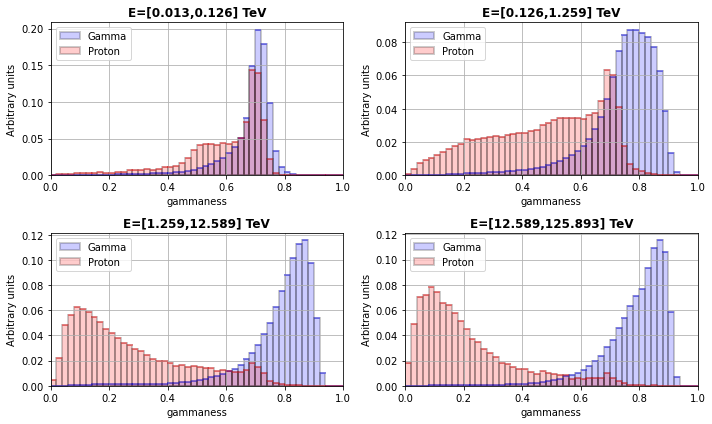

In [6]:
energy_bounds = np.logspace(np.log10(0.012589254), np.log10(125.89254), 4 + 1)
ncols = 2
n_ax = len(energy_bounds) - 1
nrows = int(n_ax / ncols) if n_ax % ncols == 0 else int((n_ax + 1) / ncols)
nrows = nrows

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows))
if nrows == 1 and ncols == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for idx in range(len(energy_bounds) - 1):
    ax = axes[idx]

    # Data selection
    query = 'true_energy >= {} and true_energy < {}'.format(energy_bounds[idx], energy_bounds[idx + 1])
    gamma = data_gamma.query(query)
    proton = data_proton.query(query + ' and offset < {}'.format(1.))
    electron = data_electron.query(query + ' and offset < {}'.format(1.))
    data_list = [gamma, proton]
    
    # Graphical stuff
    color_list = ['blue', 'red', 'green']
    edgecolor_list = ['black', 'black', 'green']
    fill_list = [True, True, False]
    ls_list = ['-', '-', '--']
    lw_list = [2, 2, 2]
    alpha_list = [0.2, 0.2, 1]
    label_list = ['Gamma', 'Proton', 'Electron']
    
    opt_list = []
    err_list = []
    for jdx, data in enumerate(data_list):
        opt_list.append(dict(edgecolor=edgecolor_list[jdx], color=color_list[jdx], fill=fill_list[jdx], ls=ls_list[jdx], lw=lw_list[jdx], alpha=alpha_list[jdx], label=label_list[jdx]))
        err_list.append(dict(ecolor=color_list[jdx], lw=lw_list[jdx], alpha=alpha_list[jdx], capsize=3, capthick=2,))
    
    for jdx, data in enumerate(data_list):
        ax = plot_hist(
            ax=ax, data=data[model_output], nbin=50, limit=output_range,
            norm=True, yerr=False,
            hist_kwargs=opt_list[jdx],
            error_kw=err_list[jdx],
        )
    ax.set_title('E=[{:.3f},{:.3f}] TeV'.format(energy_bounds[idx], energy_bounds[idx + 1]), fontdict={'weight': 'bold'})
    ax.set_xlabel(model_output)
    ax.set_ylabel('Arbitrary units')
    ax.set_xlim(output_range)
    ax.legend(loc='upper left')
    ax.grid()
    
plt.tight_layout()

fig.savefig(f"./plots/particle_classification_estimate_distribution_protopipe_{analysisName}.png")

### ROC curve
[back to top](#Table-of-contents)

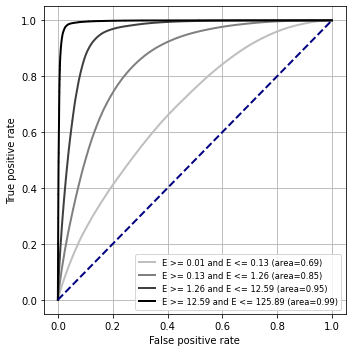

In [7]:
data = pd.concat([data_gamma, data_electron, data_proton])

plt.figure(figsize=(5,5))

ax = plt.gca()

cut_list = ['reco_energy >= {:.2f} and reco_energy <= {:.2f}'.format(
    energy_bounds[i],
    energy_bounds[i+1]
) for i in range(len(energy_bounds) - 1)]

plot_evt_roc_curve_variation(ax, data, cut_list, model_output)

ax.legend(loc='lower right', fontsize='small')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.grid()
plt.tight_layout()

fig.savefig(f"./plots/particle_classification_roc_curve_protopipe_{analysisName}.png")